In [1]:
import pandas as pd
import json
from pandas.io.json import json_normalize

%pylab inline
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

from gensim import corpora, models, similarities
from nltk.corpus import stopwords
import nltk

import snowballstemmer
import gensim

from string import ascii_lowercase

import itertools

from collections import defaultdict
import collections

from sklearn.neighbors import NearestNeighbors

Populating the interactive namespace from numpy and matplotlib


D:\Program Files\Anaconda3\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
#use data_key to import files
data_key = 'wine_notes'

#wine ids and notes
wine_notes = pd.read_pickle(data_key+'_ids'+'.pickle')

#import dictionary
dictionary = corpora.Dictionary.load(data_key+'.dict')

#import corpora
corpus_bow = corpora.MmCorpus(data_key+'_bow'+'.mm') #bag of words corpus
corpus_tfidf = corpora.MmCorpus(data_key+'_tfidf'+'.mm') #bag of words wrapped in tfidf model
corpus_lda = corpora.MmCorpus(data_key+'_lda'+'.mm') #tfidf wrapped in lda model

#import lda model
lda = models.LdaModel.load(data_key+'.lda', mmap='r')

In [3]:
#import full wine attribute data
reds = pd.read_json('red_wines.json', orient = "columns", typ='frame')
whts = pd.read_json('white_wines.json',orient = 'columns', typ='frame')
rose = pd.read_json('rose_wines.json', orient='columns', typ='frame')
sprk = pd.read_json('spark_wines.json', orient='columns', typ='frame')

#combine data_sets (wine type is in 'Varietal.WineType.Id' and 'Varietal.WineType.Name')
wine = pd.DataFrame()
wine = wine.append(reds, ignore_index = True)
wine = wine.append(whts, ignore_index = True)
wine = wine.append(rose, ignore_index = True)
wine = wine.append(sprk, ignore_index = True)

#drop duplicate IDs if they exist
wine = wine.drop_duplicates(subset='Id',keep='first')

In [4]:
lda.show_topics(num_topics=-1, formatted=False, num_words=20)

[(0,
  [('floor', 0.0057464932557614885),
   ('improv', 0.0056641674130300124),
   ('cherri', 0.0056639856348475659),
   ('black', 0.0056330229453155078),
   ('forest', 0.0055246832997931329),
   ('year', 0.0054868704323537245),
   ('pinot', 0.0050621764744976615),
   ('noir', 0.0048147200937033357),
   ('advoc', 0.0044226071365066422),
   ('spice', 0.0044106162542336298),
   ('red', 0.0043227508122427247),
   ('dark', 0.0041999588990865727),
   ('tannin', 0.0041446353834021293),
   ('next', 0.0039484447342732635),
   ('wine', 0.0037249607523202012),
   ('drink', 0.0036992848992428561),
   ('cellar', 0.0034462997009249131),
   ('nose', 0.0034362001992976981),
   ('fruit', 0.0034213866996013393),
   ('brown', 0.0033767521869805519)]),
 (1,
  [('shiraz', 0.0062800355124249538),
   ('papaya', 0.0050141998128101425),
   ('vale', 0.0048135077624762799),
   ('red', 0.0047246345137388381),
   ('mclaren', 0.0045237737629561063),
   ('total', 0.0041095271119131853),
   ('district', 0.0040594048

In [5]:
#get lda results into a dataframe...
theta, _ = lda.inference(corpus_tfidf)
theta /= theta.sum(axis=1)[:, None]

In [6]:
pd.DataFrame(theta)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.794671,0.007080,0.007080,0.007080,0.007080,0.007080,0.007080,0.007080,0.007080,0.007080,...,0.007080,0.007080,0.007080,0.007080,0.007080,0.007080,0.007080,0.007080,0.007080,0.007080
1,0.006302,0.006302,0.006302,0.006302,0.006302,0.006302,0.006302,0.006302,0.006302,0.006302,...,0.006302,0.006302,0.006302,0.006302,0.006302,0.006302,0.006302,0.006302,0.006302,0.006302
2,0.004959,0.004959,0.004959,0.004959,0.004959,0.004959,0.004959,0.004959,0.004959,0.004959,...,0.004959,0.004959,0.004959,0.004959,0.004959,0.004959,0.004959,0.004959,0.004959,0.004959
3,0.005320,0.005320,0.005320,0.005320,0.005320,0.005320,0.005320,0.005320,0.005320,0.005320,...,0.005320,0.005320,0.005320,0.125089,0.005320,0.005320,0.005320,0.005320,0.633426,0.005320
4,0.004093,0.004093,0.004093,0.004093,0.004093,0.004093,0.004093,0.004093,0.004093,0.881291,...,0.004093,0.004093,0.004093,0.004093,0.004093,0.004093,0.004093,0.004093,0.004093,0.004093
5,0.006300,0.006300,0.006300,0.006300,0.006300,0.006300,0.006300,0.006300,0.006300,0.006300,...,0.006300,0.006300,0.006300,0.006300,0.006300,0.006300,0.006300,0.006300,0.006300,0.006300
6,0.005774,0.005774,0.005774,0.005774,0.005774,0.005774,0.005774,0.005774,0.005774,0.005774,...,0.005774,0.005774,0.005774,0.005774,0.005774,0.077831,0.005774,0.005774,0.005774,0.005774
7,0.007409,0.007409,0.007409,0.007409,0.007409,0.007409,0.007409,0.333012,0.007409,0.007409,...,0.007409,0.007409,0.007409,0.007409,0.007409,0.007409,0.007409,0.007409,0.007409,0.007409
8,0.005535,0.005535,0.005535,0.005535,0.005535,0.005535,0.005535,0.005535,0.005535,0.005535,...,0.005535,0.005535,0.005535,0.005535,0.839485,0.005535,0.005535,0.005535,0.005535,0.005535
9,0.866633,0.004599,0.004599,0.004599,0.004599,0.004599,0.004599,0.004599,0.004599,0.004599,...,0.004599,0.004599,0.004599,0.004599,0.004599,0.004599,0.004599,0.004599,0.004599,0.004599


In [7]:
nbrs = NearestNeighbors(n_neighbors=21, algorithm='ball_tree').fit(theta)
distances, indices = nbrs.kneighbors(theta)

In [10]:
pd.DataFrame(distances)

,0,1,2,3,4,5,6,7,8,9,10
0,0.0,4.988819e-04,0.001323,0.001754,0.001775,0.001970,0.003328,0.003534,0.003853,0.004059,0.004984
1,0.0,3.834365e-04,0.001168,0.002355,0.003093,0.004543,0.005720,0.006331,0.007227,0.008809,0.010022
2,0.0,6.261761e-04,0.001615,0.002277,0.002400,0.002503,0.002750,0.002967,0.003303,0.004011,0.004345
3,0.0,6.560350e-02,0.068163,0.071282,0.072572,0.074094,0.074801,0.076268,0.077420,0.077545,0.078756
4,0.0,2.563511e-04,0.002947,0.006407,0.007966,0.012891,0.015626,0.016474,0.017144,0.021122,0.023457
5,0.0,4.892663e-04,0.013196,0.025782,0.031196,0.035578,0.036816,0.043498,0.044383,0.044452,0.045542
6,0.0,3.552083e-03,0.003588,0.003720,0.004527,0.005365,0.005665,0.006212,0.006601,0.006748,0.007204
7,0.0,7.396895e-03,0.013908,0.020376,0.028842,0.033009,0.033286,0.034150,0.034834,0.036576,0.037898
8,0.0,1.040700e-03,0.002012,0.002016,0.002191,0.002875,0.004069,0.007443,0.008155,0.008678,0.011893
9,0.0,1.047545e-04,0.000682,0.000688,0.002700,0.003122,0.005864,0.008988,0.012619,0.012915,0.013547


In [11]:
pd.DataFrame(indices)

,0,1,2,3,4,5,6,7,8,9,10
0,0,473,24211,1222,1782,1993,32923,29604,4560,26453,56768
1,1,236,991,745,828,14991,939,1175,733,751,1758
2,2,51251,32277,512,25330,3798,374,23416,33796,1073,63037
3,3,21663,2425,32590,33962,48348,17794,71508,47141,38809,29718
4,4,88,1055,476,1441,795,68950,1603,177,300,812
5,5,36508,29303,70370,34238,31534,47776,2094,12079,34752,67270
6,6,28629,48977,30086,66435,71753,69719,52227,12353,39947,27793
7,7,8569,7771,9340,62805,47856,40379,25370,10797,25063,45509
8,8,22202,1540,645,1306,6661,771,40267,1550,197,1670
9,9,1754,52199,1765,261,68005,72195,1353,1368,1202,1379


In [ ]:
#convert indices to wine IDs:
wine_notes.iloc[indices[10002]].Id

In [21]:
def print_matches(w, n=11):
    print(wine_notes.iloc[indices[w]].Id)
    print("")
    for i in range(n):
        ind = indices[w][i]
        print("distance:",distances[w][i])
        print(wine[wine.Id==wine_notes.iloc[ind].Id][['Id','Name','Vintage','Varietal.Name','Appellation.Name','Appellation.Region.Name']])
        print(wine_notes.iloc[ind][['Notes']].tolist())
        print("")

In [22]:
print_matches(4)

4         90927
88        44684
1055     166643
476      157321
1441     146944
795      143431
68950    161447
1603     147778
177      210810
300      196287
812       97765
Name: Id, dtype: int64

distance: 0.0
          Id                          Name Vintage Varietal.Name  \
12206  90927  Chateau St. Jean Merlot 2004    2004        Merlot   

      Appellation.Name Appellation.Region.Name  
12206    Sonoma County              California  
['Winemaker\'s Notes:  The Alexander Valley grapes highlight bright cherry flavors while the Knights Valley and Dry Creek Valleys give cassis flavors and elegant structure. The Sonoma Valley is home to the St. Jean Estate Vineyard and produces black and dense grapes with supple tannins. The cooler Russian River Valley and Carneros regions contribute black, exotic aromas and firm structure. "Aromas of blueberry, cherry, plum and dried herbs burst from the glass of this Merlot. These bright fruit characters carry over onto the palate and mix with 

In [24]:
print_matches(10002)

10002     75987
60402     89058
31130    148714
30365    130272
69938    120767
13289    156096
38781    149131
34202    143011
68283    143005
71410    134732
19834    116242
Name: Id, dtype: int64

distance: 0.0
          Id                       Name Vintage Varietal.Name  \
75259  75987  J. Garcia Chardonnay 2003    2003    Chardonnay   

      Appellation.Name Appellation.Region.Name  
75259    Sonoma County              California  
["Winemaker's Notes:  Jerry Garcia was an artist of surprising range and accomplishment. To celebrate his creativity, Clos du Bois has joined with the Garcia Estate to produce a series of special bottlings. The inaugural release of the J. Garcia wines features three of Jerry's favorites: Chardonnay, Merlot and Cabernet Sauvignon each featuring a unique piece of his art on the label. The 2002 vintage was a winemaker's dream for white wines — and this Chardonnay is no exception. Sourced from vineyards in Dry Creek, Alexander Valley and the cool Russian 

In [ ]:
i = 10002
comp1, comp2 = indices[i][0], indices[i][1]

print(comp1, comp2, distances[i][1])

print(theta[comp1])
print(theta[comp2])

print(wine_notes.iloc[comp1].Id)
print(wine_notes.iloc[comp2].Id)

print(wine_notes.iloc[comp1].Notes)
print(wine_notes.iloc[comp2].Notes)

print(wine[wine.Id==wine_notes.iloc[comp1].Id][['Id','Name','Vintage','Varietal.Name']])
print(wine[wine.Id==wine_notes.iloc[comp2].Id][['Id','Name','Vintage','Varietal.Name']])

In [ ]:
pd.DataFrame(theta).describe()

In [25]:
test1 = [pd.Series(pd.DataFrame(theta).round(1)[i]).value_counts().sort_index() for i in range(30)]

In [ ]:
pd.DataFrame(test1).T.iloc[:,12]

In [ ]:
pd.DataFrame(test1).T.iloc[1:]

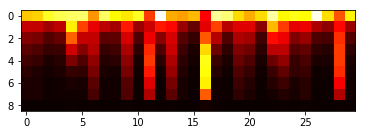

In [26]:
plt.imshow(np.array(test1).T[1:], cmap='hot', interpolation='nearest')
plt.show()

In [ ]:
wine.columns

In [ ]:
wine['Varietal.Name'].value_counts()

In [ ]:
wine[wine['Varietal.Name']=='Cabernet Sauvignon'][['Id','Name']]

In [ ]:
i = 1
print(corpus_lda[i])
print(wine_notes.iloc[i].Id)
wine[wine.Id==wine_notes.iloc[i].Id][['Id','Name','Varietal.Name']]

In [ ]:
wine_notes.Id

In [27]:
varietals = [wine[wine.Id == w]['Varietal.Name'].tolist() for w in wine_notes.Id]
pd.DataFrame(varietals)

,0
0,Rhone Red Blends
1,Nebbiolo
2,Cabernet Sauvignon
3,Chardonnay
4,Merlot
5,Barbera
6,Syrah/Shiraz
7,Tempranillo
8,Pinot Noir
9,Cabernet Sauvignon


In [ ]:
wine[wine.Id==wine_notes.Id[0]]